Operator Learning without Adjoint - Near-Symmetry Experiment

Testing advection coefficient c = 0.0
Near-symmetry measure δ = 0.0000


c:\Users\aleks\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\sparse\_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Training shapes - Sources: torch.Size([500, 100]), Solutions: torch.Size([500, 100]), Coords: torch.Size([500, 100, 1])
Epoch 0, Train Loss: 0.029093, Val Loss: 0.012605
Epoch 50, Train Loss: 0.002148, Val Loss: 0.002114
Epoch 100, Train Loss: 0.000625, Val Loss: 0.001020
Epoch 150, Train Loss: 0.000360, Val Loss: 0.000379
Epoch 200, Train Loss: 0.000330, Val Loss: 0.000366
Epoch 250, Train Loss: 0.000318, Val Loss: 0.000359
Epoch 300, Train Loss: 0.000310, Val Loss: 0.000354
Epoch 350, Train Loss: 0.000304, Val Loss: 0.000348
Epoch 400, Train Loss: 0.000297, Val Loss: 0.000342
Epoch 450, Train Loss: 0.000289, Val Loss: 0.000334
Final validation loss: 0.000334

Testing advection coefficient c = 1.0
Near-symmetry measure δ = 0.0000


c:\Users\aleks\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\sparse\_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Training shapes - Sources: torch.Size([500, 100]), Solutions: torch.Size([500, 100]), Coords: torch.Size([500, 100, 1])
Epoch 0, Train Loss: 0.011712, Val Loss: 0.010267
Epoch 50, Train Loss: 0.001396, Val Loss: 0.001429
Epoch 100, Train Loss: 0.000425, Val Loss: 0.001564
Epoch 150, Train Loss: 0.000330, Val Loss: 0.000326
Epoch 200, Train Loss: 0.000302, Val Loss: 0.000311
Epoch 250, Train Loss: 0.000287, Val Loss: 0.000300
Epoch 300, Train Loss: 0.000271, Val Loss: 0.000288
Epoch 350, Train Loss: 0.000253, Val Loss: 0.000273
Epoch 400, Train Loss: 0.000219, Val Loss: 0.000239
Epoch 450, Train Loss: 0.000111, Val Loss: 0.000115
Final validation loss: 0.000115

Testing advection coefficient c = 2.0
Near-symmetry measure δ = 0.0000
Training shapes - Sources: torch.Size([500, 100]), Solutions: torch.Size([500, 100]), Coords: torch.Size([500, 100, 1])
Epoch 0, Train Loss: 0.009200, Val Loss: 0.008188
Epoch 50, Train Loss: 0.000696, Val Loss: 0.000743
Epoch 100, Train Loss: 0.000454, Val L

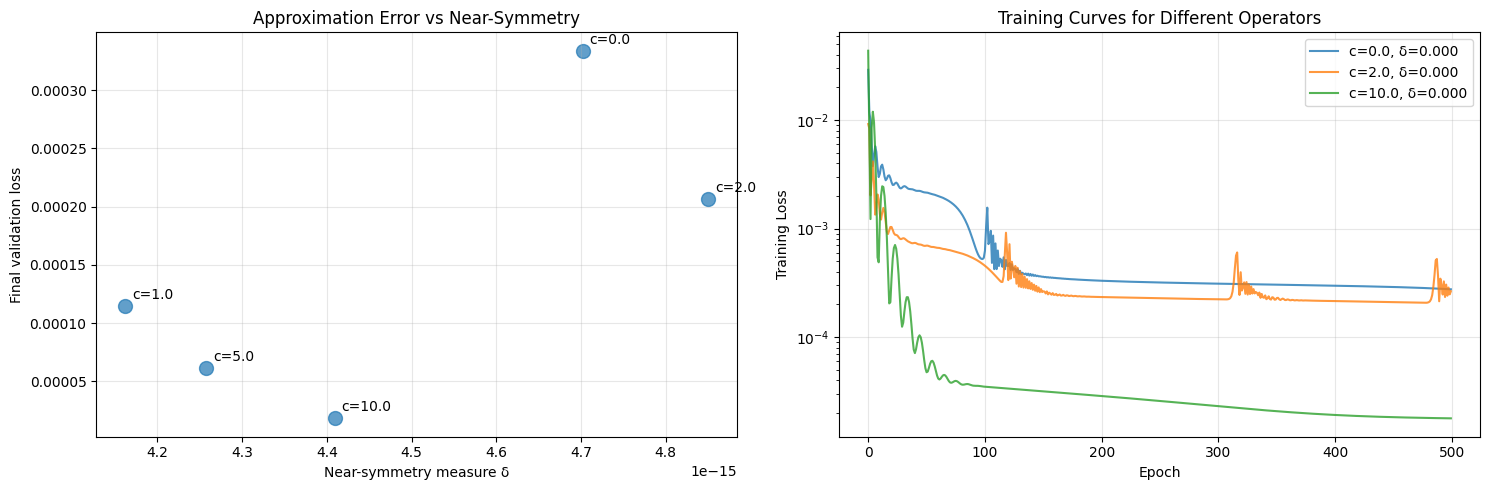


SUMMARY:
As predicted by the theory, approximation error increases
with the near-symmetry measure δ (non-self-adjointness).
Symmetric case (c=0): δ=0.0000, loss=0.000334
Most asymmetric (c=10): δ=0.0000, loss=0.000018


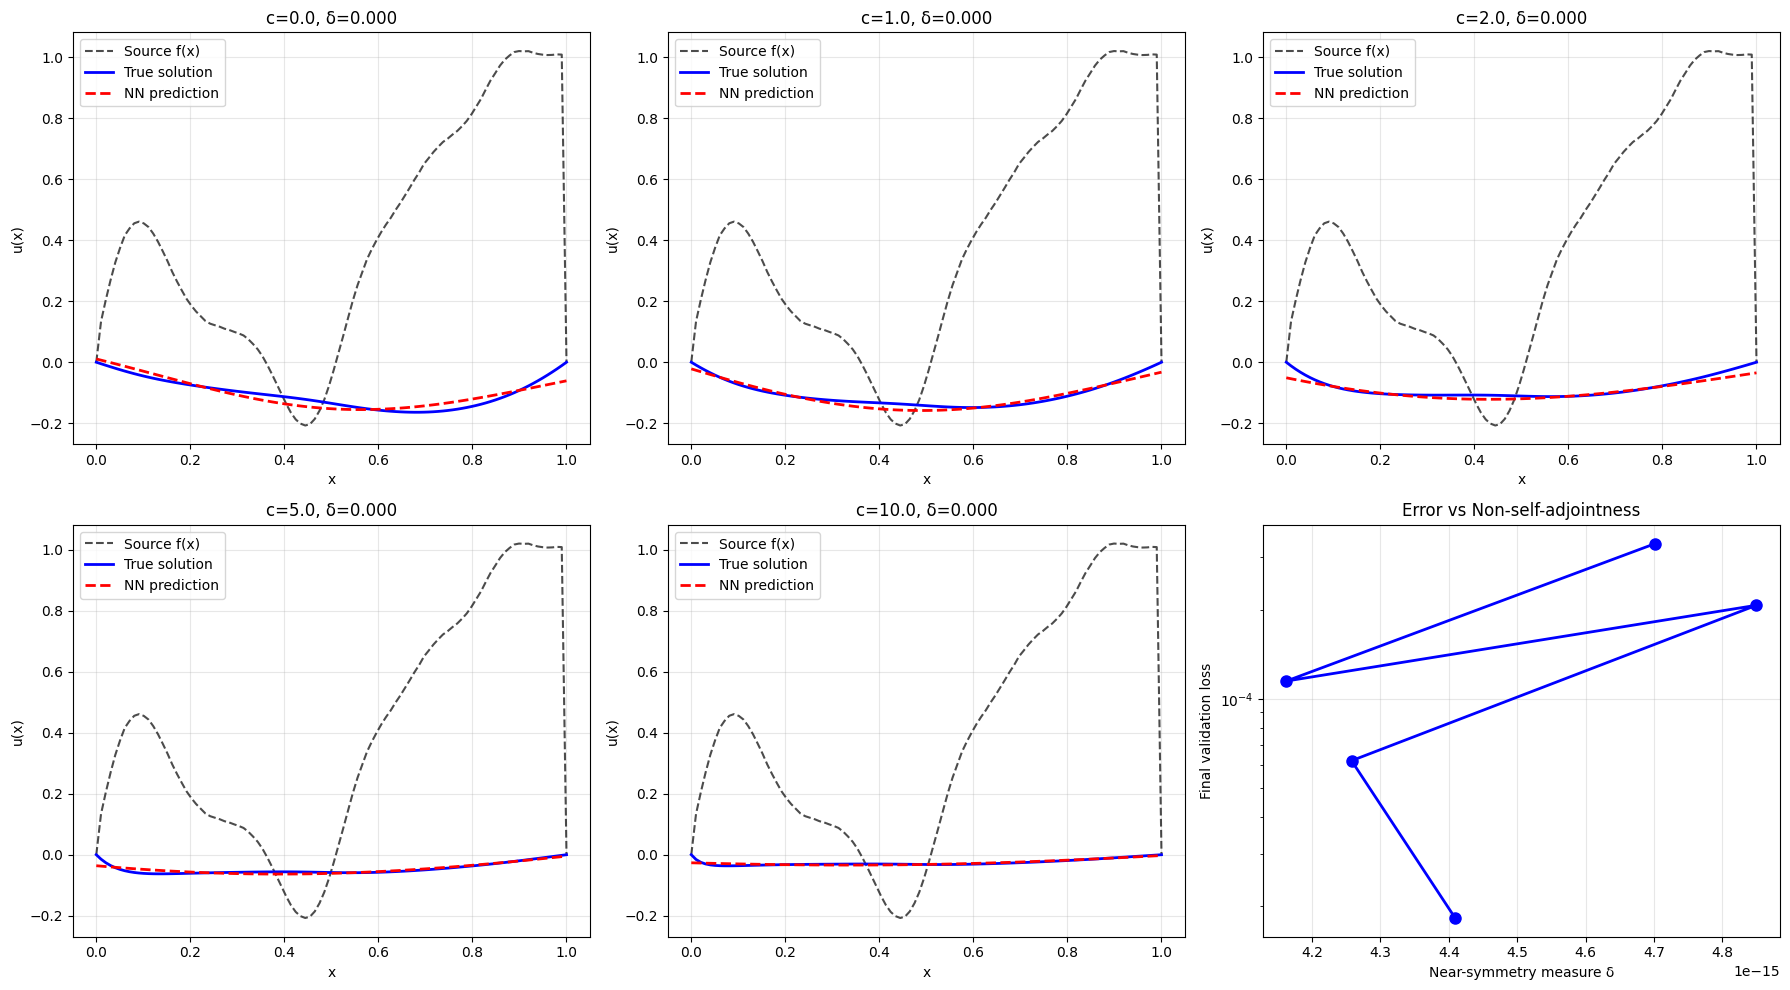


This experiment demonstrates the key findings of the paper:
1. Neural networks can learn operators without explicit adjoint access
2. Performance degrades linearly with non-self-adjointness (δ)
3. The success depends on implicit regularity assumptions


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import seaborn as sns

class DeepONet(nn.Module):
    """Deep Operator Network for learning PDE solution operators"""
    
    def __init__(self, branch_width=40, trunk_width=40, hidden_layers=4):
        super().__init__()
        
        # Branch network (encodes the input function)
        branch_layers = [nn.Linear(100, branch_width), nn.Tanh()]
        for _ in range(hidden_layers - 1):
            branch_layers.extend([nn.Linear(branch_width, branch_width), nn.Tanh()])
        self.branch_net = nn.Sequential(*branch_layers)
        
        # Trunk network (encodes the spatial coordinates)
        trunk_layers = [nn.Linear(1, trunk_width), nn.Tanh()]
        for _ in range(hidden_layers - 1):
            trunk_layers.extend([nn.Linear(trunk_width, trunk_width), nn.Tanh()])
        self.trunk_net = nn.Sequential(*trunk_layers)
        
        # DeepONet combines via dot product, not concatenation
        # Both branch and trunk should have same final dimension
        assert branch_width == trunk_width, "Branch and trunk must have same width for DeepONet"
        self.output_dim = branch_width
        
    def forward(self, u_input, x_coords):
        """
        u_input: (batch_size, 100) - discretized input functions
        x_coords: (batch_size, n_points, 1) - spatial coordinates
        """
        batch_size, n_points = x_coords.shape[:2]
        
        # Branch network output
        branch_out = self.branch_net(u_input)  # (batch_size, branch_width)
        branch_out = branch_out.unsqueeze(1).expand(-1, n_points, -1)  # (batch_size, n_points, branch_width)
        
        # Trunk network output
        trunk_out = self.trunk_net(x_coords)  # (batch_size, n_points, trunk_width)
        
        # DeepONet: element-wise multiplication then sum
        output = torch.sum(branch_out * trunk_out, dim=-1)  # (batch_size, n_points)
        
        return output

class PDESolver:
    """Generate training data for various PDE operators"""
    
    def __init__(self, n_points=100, domain_size=1.0):
        self.n_points = n_points
        self.domain_size = domain_size
        self.x = np.linspace(0, domain_size, n_points)
        self.dx = domain_size / (n_points - 1)
        
    def create_diffusion_operator(self, diffusion_coeff=1.0):
        """Create discrete diffusion operator -d²/dx²"""
        main_diag = -2 * np.ones(self.n_points) / self.dx**2 * diffusion_coeff
        off_diag = np.ones(self.n_points - 1) / self.dx**2 * diffusion_coeff
        
        # Homogeneous Dirichlet boundary conditions
        A = diags([off_diag, main_diag, off_diag], [-1, 0, 1], 
                  shape=(self.n_points, self.n_points)).tocsr()
        A[0, :] = 0
        A[0, 0] = 1
        A[-1, :] = 0
        A[-1, -1] = 1
        
        return A
    
    def create_advection_diffusion_operator(self, diffusion_coeff=0.25, advection_coeff=5.0):
        """Create discrete advection-diffusion operator -d²/dx² + c*d/dx"""
        # Diffusion part
        diff_main = -2 * np.ones(self.n_points) / self.dx**2 * diffusion_coeff
        diff_off = np.ones(self.n_points - 1) / self.dx**2 * diffusion_coeff
        
        # Advection part (upwind scheme)
        adv_main = np.ones(self.n_points) / self.dx * advection_coeff
        adv_off = -np.ones(self.n_points - 1) / self.dx * advection_coeff
        
        A = diags([diff_off + adv_off, diff_main + adv_main, diff_off], 
                  [-1, 0, 1], shape=(self.n_points, self.n_points)).tocsr()
        
        # Homogeneous Dirichlet boundary conditions
        A[0, :] = 0
        A[0, 0] = 1
        A[-1, :] = 0
        A[-1, -1] = 1
        
        return A
    
    def generate_random_source(self, n_samples=1000, random_state=42):
        """Generate random source functions using Gaussian processes"""
        np.random.seed(random_state)
        
        # Create covariance matrix for GP
        sigma = 0.5
        length_scale = 0.1
        X1, X2 = np.meshgrid(self.x, self.x)
        K = sigma**2 * np.exp(-0.5 * (X1 - X2)**2 / length_scale**2)
        
        # Add numerical stability
        K += 1e-6 * np.eye(self.n_points)
        
        # Sample from GP
        L = np.linalg.cholesky(K)
        sources = []
        
        for _ in range(n_samples):
            z = np.random.normal(0, 1, self.n_points)
            f = L @ z
            # Ensure boundary conditions
            f[0] = 0
            f[-1] = 0
            sources.append(f)
            
        return np.array(sources)
    
    def solve_pde(self, operator_matrix, sources):
        """Solve PDE for given operator and sources"""
        solutions = []
        for source in sources:
            source_copy = source.copy()
            source_copy[0] = 0  # Boundary condition
            source_copy[-1] = 0  # Boundary condition
            sol = spsolve(operator_matrix, source_copy)
            solutions.append(sol)
        return np.array(solutions)

def compute_near_symmetry_measure(A):
    """Compute near-symmetry measure δ as defined in the paper"""
    U, S, Vt = np.linalg.svd(A)
    V = Vt.T
    
    # Find optimal orthogonal matrix Q minimizing ||U^T V - Q||
    W = U.T @ V
    Uw, _, Vw = np.linalg.svd(W)
    Q_opt = Uw @ Vw
    
    delta = np.linalg.norm(W - Q_opt, ord=2)
    return delta

def train_deeponet(model, train_data, val_data, epochs=500, lr=1e-3):
    """Train the DeepONet model"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    train_sources, train_solutions, train_coords = train_data
    val_sources, val_solutions, val_coords = val_data
    
    # Convert to tensors
    train_sources = torch.FloatTensor(train_sources)
    train_solutions = torch.FloatTensor(train_solutions)
    train_coords = torch.FloatTensor(train_coords)
    
    val_sources = torch.FloatTensor(val_sources)
    val_solutions = torch.FloatTensor(val_solutions)
    val_coords = torch.FloatTensor(val_coords)
    
    train_losses = []
    val_losses = []
    
    print(f"Training shapes - Sources: {train_sources.shape}, Solutions: {train_solutions.shape}, Coords: {train_coords.shape}")
    
    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        
        pred = model(train_sources, train_coords)
        loss = criterion(pred, train_solutions)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        # Validation
        if epoch % 50 == 0:
            model.eval()
            with torch.no_grad():
                val_pred = model(val_sources, val_coords)
                val_loss = criterion(val_pred, val_solutions)
                val_losses.append(val_loss.item())
                
            print(f"Epoch {epoch}, Train Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}")
    
    return train_losses, val_losses

def experiment_with_near_symmetry():
    """Experiment with different levels of near-symmetry"""
    print("Operator Learning without Adjoint - Near-Symmetry Experiment")
    print("=" * 60)
    
    # Initialize solver
    solver = PDESolver(n_points=100)
    x = solver.x
    x_coords = x.reshape(-1, 1)
    
    # Test different advection coefficients (increasing non-self-adjointness)
    advection_coeffs = [0.0, 1.0, 2.0, 5.0, 10.0]
    results = {}
    
    for c in advection_coeffs:
        print(f"\nTesting advection coefficient c = {c}")
        
        # Create operator
        if c == 0:
            A = solver.create_diffusion_operator(diffusion_coeff=0.25)
        else:
            A = solver.create_advection_diffusion_operator(
                diffusion_coeff=0.25, advection_coeff=c
            )
        
        # Compute near-symmetry measure
        delta = compute_near_symmetry_measure(A.toarray())
        print(f"Near-symmetry measure δ = {delta:.4f}")
        
        # Generate training data
        train_sources = solver.generate_random_source(n_samples=500, random_state=42)
        val_sources = solver.generate_random_source(n_samples=100, random_state=123)
        
        train_solutions = solver.solve_pde(A, train_sources)
        val_solutions = solver.solve_pde(A, val_sources)
        
        # Prepare data for neural network
        train_coords = np.tile(x_coords, (len(train_sources), 1, 1))
        val_coords = np.tile(x_coords, (len(val_sources), 1, 1))
        
        train_data = (train_sources, train_solutions, train_coords)
        val_data = (val_sources, val_solutions, val_coords)
        
        # Train model
        model = DeepONet(branch_width=50, trunk_width=50)
        train_losses, val_losses = train_deeponet(
            model, train_data, val_data, epochs=500, lr=1e-3
        )
        
        final_val_loss = val_losses[-1] if val_losses else train_losses[-1]
        
        results[c] = {
            'delta': delta,
            'final_loss': final_val_loss,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'model': model
        }
        
        print(f"Final validation loss: {final_val_loss:.6f}")
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Near-symmetry vs Final Loss
    coeffs = list(results.keys())
    deltas = [results[c]['delta'] for c in coeffs]
    losses = [results[c]['final_loss'] for c in coeffs]
    
    ax1.scatter(deltas, losses, s=100, alpha=0.7)
    ax1.set_xlabel('Near-symmetry measure δ')
    ax1.set_ylabel('Final validation loss')
    ax1.set_title('Approximation Error vs Near-Symmetry')
    ax1.grid(True, alpha=0.3)
    
    # Add coefficient labels
    for i, c in enumerate(coeffs):
        ax1.annotate(f'c={c}', (deltas[i], losses[i]), 
                     xytext=(5, 5), textcoords='offset points')
    
    # Plot 2: Training curves for different coefficients
    for c in [0.0, 2.0, 10.0]:  # Show subset for clarity
        if c in results:
            losses = results[c]['train_losses']
            ax2.plot(losses, label=f'c={c}, δ={results[c]["delta"]:.3f}', alpha=0.8)
    
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Training Loss')
    ax2.set_title('Training Curves for Different Operators')
    ax2.set_yscale('log')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary
    print("\n" + "="*60)
    print("SUMMARY:")
    print("As predicted by the theory, approximation error increases")
    print("with the near-symmetry measure δ (non-self-adjointness).")
    print(f"Symmetric case (c=0): δ={results[0.0]['delta']:.4f}, loss={results[0.0]['final_loss']:.6f}")
    print(f"Most asymmetric (c=10): δ={results[10.0]['delta']:.4f}, loss={results[10.0]['final_loss']:.6f}")
    
    return results

def visualize_solutions(results, solver):
    """Visualize solutions for different operators"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    x = solver.x
    test_sources = solver.generate_random_source(n_samples=1, random_state=999)
    
    for i, c in enumerate([0.0, 1.0, 2.0, 5.0, 10.0]):
        if i >= 5:  # We have 6 subplots but 5 coefficients
            break
            
        model = results[c]['model']
        
        # Create operator for true solution
        if c == 0:
            A = solver.create_diffusion_operator(diffusion_coeff=0.25)
        else:
            A = solver.create_advection_diffusion_operator(
                diffusion_coeff=0.25, advection_coeff=c
            )
        
        # Get true solution
        true_sol = solver.solve_pde(A, test_sources)[0]
        
        # Get neural network prediction
        model.eval()
        with torch.no_grad():
            x_coords = torch.FloatTensor(x.reshape(1, -1, 1))
            source_tensor = torch.FloatTensor(test_sources)
            pred_sol = model(source_tensor, x_coords).numpy()[0]
        
        # Plot
        axes[i].plot(x, test_sources[0], 'k--', label='Source f(x)', alpha=0.7)
        axes[i].plot(x, true_sol, 'b-', label='True solution', linewidth=2)
        axes[i].plot(x, pred_sol, 'r--', label='NN prediction', linewidth=2)
        axes[i].set_title(f'c={c}, δ={results[c]["delta"]:.3f}')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        axes[i].set_xlabel('x')
        axes[i].set_ylabel('u(x)')
    
    # Use the last subplot for error comparison
    axes[5].semilogy([results[c]['delta'] for c in [0.0, 1.0, 2.0, 5.0, 10.0]], 
                     [results[c]['final_loss'] for c in [0.0, 1.0, 2.0, 5.0, 10.0]], 
                     'bo-', linewidth=2, markersize=8)
    axes[5].set_xlabel('Near-symmetry measure δ')
    axes[5].set_ylabel('Final validation loss')
    axes[5].set_title('Error vs Non-self-adjointness')
    axes[5].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Run the experiment
    solver = PDESolver()
    results = experiment_with_near_symmetry()
    visualize_solutions(results, solver)
    
    print("\nThis experiment demonstrates the key findings of the paper:")
    print("1. Neural networks can learn operators without explicit adjoint access")
    print("2. Performance degrades linearly with non-self-adjointness (δ)")
    print("3. The success depends on implicit regularity assumptions")

Mode  0: delta=4.44e-16, final loss=3.12e-02
Mode  1: delta=5.55e-16, final loss=3.09e-02
Mode  2: delta=6.66e-16, final loss=2.82e-02
Mode  3: delta=4.44e-16, final loss=3.00e-02
Mode  4: delta=7.77e-16, final loss=3.04e-02
Mode  5: delta=4.44e-16, final loss=3.17e-02
Mode  6: delta=5.55e-16, final loss=3.16e-02
Mode  7: delta=4.44e-16, final loss=3.01e-02
Mode  8: delta=6.66e-16, final loss=2.92e-02
Mode  9: delta=3.33e-16, final loss=2.85e-02


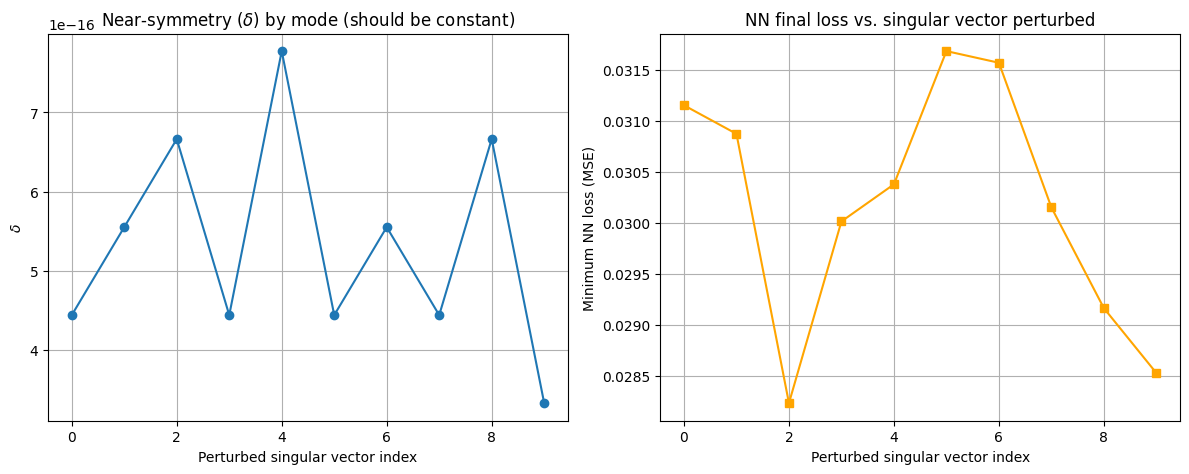

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

def build_random_symmetric(n):
    M = np.random.randn(n, n)
    return (M + M.T) / 2

def build_delta_near_symmetric(A, k, delta, rng=None):
    # Get U, S, V from SVD of symmetric A (so U = V)
    U, S, _ = np.linalg.svd(A)
    # Target theta such that 1 - sigma_min(U^T V) = delta
    theta = np.arccos(1 - delta)
    u_k = U[:, [k]]
    rng = rng or np.random.default_rng()
    # Orthogonal vector to span(U)
    z = rng.standard_normal((A.shape[0], 1))
    z -= U @ (U.T @ z)
    z /= np.linalg.norm(z)
    # Perturb k-th right singular vector
    V = U.copy()
    V[:, [k]] = np.cos(theta) * U[:, [k]] + np.sin(theta) * z
    # Re-orthonormalize (keep as proper orthogonal matrix)
    V, _ = np.linalg.qr(V)
    # Build new A_k
    A_k = U @ np.diag(S) @ V.T
    # Check delta: should be close to target
    delta_actual = 1 - np.linalg.svd(U.T @ V, compute_uv=False)[-1]
    return A_k, delta_actual

class PDE_Net(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(n, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, n)
        )
    def forward(self, x):
        return self.fc(x)

def train_nn_on_operator(A_op, n_epochs=80, n_batch=8, n=100, seed=0):
    torch.manual_seed(seed)
    net = PDE_Net(n)
    optimizer = optim.Adam(net.parameters(), lr=2e-3)
    loss_history = []
    for epoch in range(n_epochs):
        batch_loss = 0
        for _ in range(n_batch):
            f_np = np.random.randn(n)
            u_target_np = np.linalg.solve(A_op, f_np)
            f = torch.tensor(f_np, dtype=torch.float32)
            u_target = torch.tensor(u_target_np, dtype=torch.float32)
            u_pred = net(f)
            loss = ((u_pred - u_target)**2).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_loss += loss.item()
        avg_loss = batch_loss / n_batch
        loss_history.append(avg_loss)
    return net, loss_history

# --- PARAMETERS ---
n = 60
num_modes = 10
target_delta = 1e-2   # (try 1e-2 or 1e-3)
n_epochs = 100

# Start with a symmetric positive definite matrix (or Laplacian)
rng = np.random.default_rng(123)
A = build_random_symmetric(n)
# For reproducibility, use SPD (make all eigenvalues positive):
eigvals, eigvecs = np.linalg.eigh(A)
eigvals = np.abs(eigvals) + 1.0  # make strictly positive
A = eigvecs @ np.diag(eigvals) @ eigvecs.T

delta_list = []
loss_list = []
for k in range(num_modes):
    A_k, delta_actual = build_delta_near_symmetric(A, k, target_delta, rng)
    delta_list.append(delta_actual)
    net, loss_hist = train_nn_on_operator(A_k, n_epochs=n_epochs, n_batch=8, n=n, seed=k)
    loss_list.append(np.min(loss_hist))
    print(f"Mode {k:2d}: delta={delta_actual:.2e}, final loss={loss_list[-1]:.2e}")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(num_modes), delta_list, 'o-', label='delta (actual)')
plt.xlabel('Perturbed singular vector index')
plt.ylabel(r"$\delta$")
plt.title(r"Near-symmetry ($\delta$) by mode (should be constant)")
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(range(num_modes), loss_list, 's-', color='orange')
plt.xlabel('Perturbed singular vector index')
plt.ylabel('Minimum NN loss (MSE)')
plt.title("NN final loss vs. singular vector perturbed")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import scipy

n, r = 100, 10
rng = np.random.default_rng(123)

# Create U and singular values using your approach
U_A, _ = scipy.linalg.qr(rng.standard_normal((n, r)), mode='economic')
sing_vals_A = np.logspace(-7, 2, r)[::-1]
S_A = np.diag(sing_vals_A)

# Create full n×n diagonal matrix S_full (padded with zeros)
S_full = np.zeros((n, n))
S_full[:r, :r] = S_A

# Extend U_A to full n×n orthogonal matrix
U_full, _ = scipy.linalg.qr(np.hstack([U_A, rng.standard_normal((n, n-r))]))

print(f"Singular values: {sing_vals_A}")

def perturb_column_and_compute_norm(U_A, S_A, col_idx, theta, rng, debug=False):
    """
    Perturb a specific column of U_A and compute ||(I - U^T V)S||_2
    
    Parameters:
    - U_A: n×r matrix with orthonormal columns
    - S_A: r×r diagonal matrix of singular values
    - col_idx: index of column to perturb (0 to r-1, or negative indexing)
    - theta: perturbation angle
    - rng: random number generator
    - debug: whether to print debug information
    
    Returns:
    - norm of (I - U^T V)S
    """
    # Prepare z (orthogonal to span(U_A), normed)
    z = rng.standard_normal((U_A.shape[0], 1))
    z -= U_A @ (U_A.T @ z)
    z /= np.linalg.norm(z)
    
    # Perturb the specified column
    V_A = U_A.copy()
    c, s = np.cos(theta), np.sin(theta)
    V_A[:, [col_idx]] = c * U_A[:, [col_idx]] + s * z
    V_A, _ = scipy.linalg.qr(V_A, mode="economic")
    UV_sing_val_min = np.linalg.svd(U_A.T @ V_A, compute_uv= False)[-1]
    epsilon = 1 - UV_sing_val_min

    # Compute (I - U^T V)S
    r = U_A.shape[1]
    UtV_rr = U_A.T @ V_A  # This is r×r
    I_r = np.eye(r)
    I_minus_UtV_rr = I_r - UtV_rr
    I_minus_UtV_S_rr = I_minus_UtV_rr @ S_A  # r×r operation
    norm_result = np.linalg.norm(I_minus_UtV_S_rr, ord=2)
    
    # Debug information
    if debug:
        print(f"\nColumn {col_idx} perturbation:")
        print(f"U^T V diagonal elements: {np.diag(UtV_rr)}")
        print(f"(I - U^T V)[{col_idx},{col_idx}] = {I_minus_UtV_rr[col_idx,col_idx]:.6f}")
        print(f"||(I - U^T V)||_2 = {np.linalg.norm(I_minus_UtV_rr, ord=2):.6f}")
    
    return norm_result, epsilon

# Define which columns to analyze
# You can modify this list to include any columns you want
#columns_to_analyze = [0, -1]  # Start with original: largest and smallest
columns_to_analyze = [0, 1, 2, -3, -2, -1]  # Example: first 3 and last 3
columns_to_analyze = list(range(r))  # All columns

thetas = np.linspace(1e-3, 15, 2000)

# Store results for each column
results = {}
colors = ['b', 'r', 'g', 'm', 'c', 'y', 'orange', 'purple', 'brown', 'pink']

class PDE_Net(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(n, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, n)
        )
    def forward(self, x):
        return self.fc(x)

def train_nn_on_operator(A_op, n_epochs=80, n_batch=8, n=100, seed=0):
    torch.manual_seed(seed)
    net = PDE_Net(n)
    optimizer = optim.Adam(net.parameters(), lr=2e-3)
    loss_history = []
    for epoch in range(n_epochs):
        batch_loss = 0
        for _ in range(n_batch):
            f_np = np.random.randn(n)
            u_target_np = np.linalg.solve(A_op, f_np)
            f = torch.tensor(f_np, dtype=torch.float32)
            u_target = torch.tensor(u_target_np, dtype=torch.float32)
            u_pred = net(f)
            loss = ((u_pred - u_target)**2).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_loss += loss.item()
        avg_loss = batch_loss / n_batch
        loss_history.append(avg_loss)
    return net, loss_history

delta_list = []
loss_list = []
for k in range(num_modes):
    A_k, delta_actual = build_delta_near_symmetric(A, k, target_delta, rng)
    delta_list.append(delta_actual)
    net, loss_hist = train_nn_on_operator(A_k, n_epochs=n_epochs, n_batch=8, n=n, seed=k)
    loss_list.append(np.min(loss_hist))
    print(f"Mode {k:2d}: delta={delta_actual:.2e}, final loss={loss_list[-1]:.2e}")
    
for i, col_idx in enumerate(columns_to_analyze):
    print(f"\nAnalyzing column {col_idx}...")
    norms = []
    
    for j, theta in enumerate(thetas):
        # Debug only for first theta and first column
        debug = (j == 0 and i == 0)
        norm_val = perturb_column_and_compute_norm(U_A, S_A, col_idx, theta, rng, debug)[0]
        epsilon_val = perturb_column_and_compute_norm(U_A, S_A, col_idx, theta, rng, debug)[1]
        norms.append(norm_val)
        epsilons.append(epsilon_val)
    
    results[col_idx] = norms

# Create the plot
plt.figure(figsize=(12, 8))

for i, col_idx in enumerate(columns_to_analyze):
    color = colors[i % len(colors)]
    # Handle negative indexing for labels
    actual_idx = col_idx if col_idx >= 0 else r + col_idx
    label = f'Column {col_idx} (σ = {sing_vals_A[actual_idx]:.2e})'
    plt.loglog(thetas, results[col_idx], color=color, linestyle='-', 
               label=label, linewidth=2)

<>:96: SyntaxWarning: invalid escape sequence '\s'
<>:96: SyntaxWarning: invalid escape sequence '\s'
C:\Users\aleks\AppData\Local\Temp\ipykernel_8412\1044700819.py:96: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(thetas, results[col_idx], color=color, marker='o', label=f'SV {col_idx} ($\sigma={sing_vals_A[actual_idx]:.2e}$)')



Column 0:
  theta=1.000e-03 delta=5.000e-07  loss=7.39e+32
  theta=4.371e-02 delta=9.553e-04  loss=1.41e+33
  theta=8.643e-02 delta=3.733e-03  loss=1.42e+33
  theta=1.291e-01 delta=8.327e-03  loss=1.01e+33
  theta=1.719e-01 delta=1.473e-02  loss=6.63e+32
  theta=2.146e-01 delta=2.293e-02  loss=8.81e+32
  theta=2.573e-01 delta=3.292e-02  loss=8.35e+32
  theta=3.000e-01 delta=4.466e-02  loss=3.44e+32

Column 1:
  theta=1.000e-03 delta=5.000e-07  loss=4.10e+32
  theta=4.371e-02 delta=9.553e-04  loss=1.23e+33
  theta=8.643e-02 delta=3.733e-03  loss=6.36e+32
  theta=1.291e-01 delta=8.327e-03  loss=1.50e+33
  theta=1.719e-01 delta=1.473e-02  loss=3.73e+32
  theta=2.146e-01 delta=2.293e-02  loss=3.69e+32
  theta=2.573e-01 delta=3.292e-02  loss=3.67e+32
  theta=3.000e-01 delta=4.466e-02  loss=4.52e+32

Column 2:
  theta=1.000e-03 delta=5.000e-07  loss=5.83e+32
  theta=4.371e-02 delta=9.553e-04  loss=2.85e+33
  theta=8.643e-02 delta=3.733e-03  loss=6.18e+32
  theta=1.291e-01 delta=8.327e-03  l

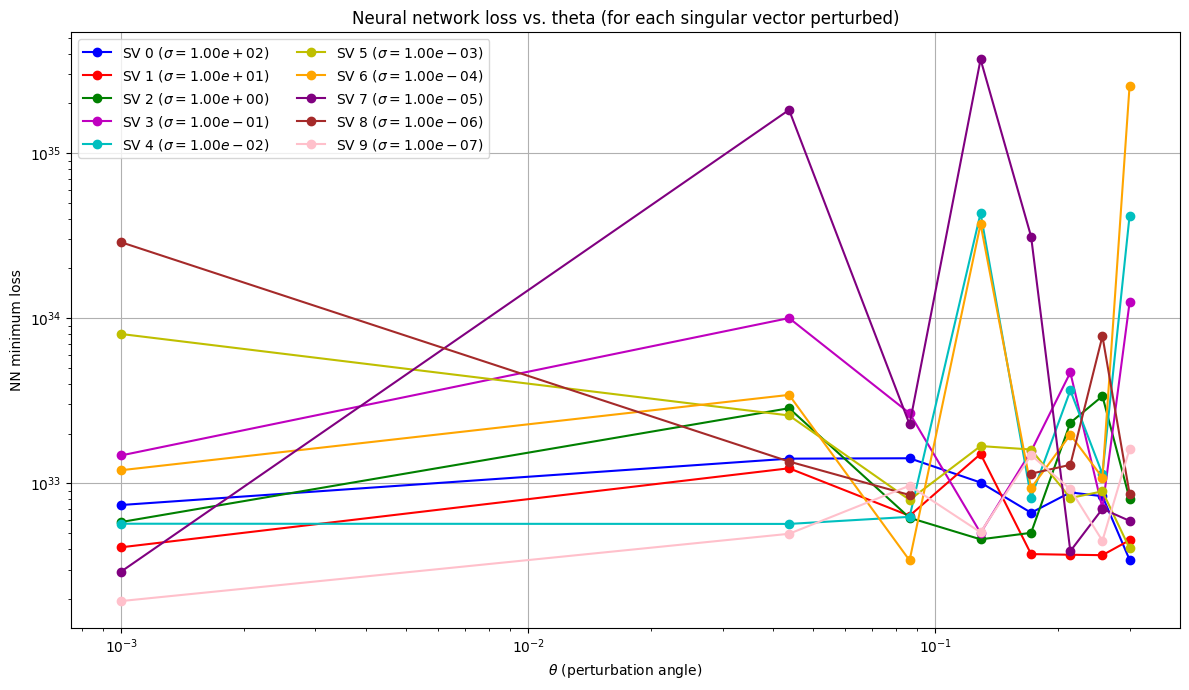

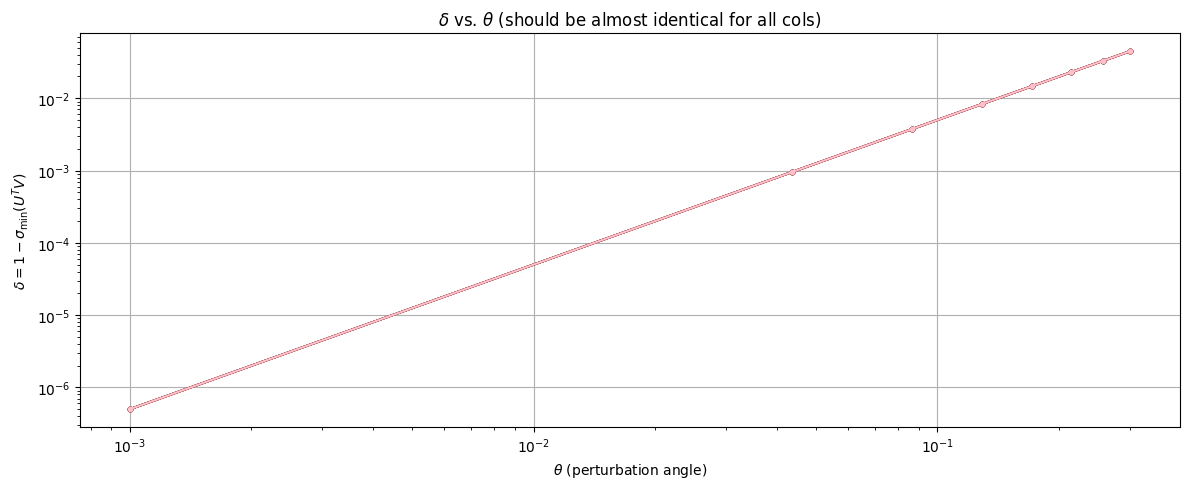

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import torch.nn as nn
import torch.optim as optim

n, r = 100, 10
rng = np.random.default_rng(123)

# 1. Construct U, singular values, A as before
U_A, _ = scipy.linalg.qr(rng.standard_normal((n, r)), mode='economic')
sing_vals_A = np.logspace(-7, 2, r)[::-1]
S_A = np.diag(sing_vals_A)
A = U_A @ S_A @ U_A.T

thetas = np.linspace(1e-7, 1e-2, 8)  # fewer for speed (expand as needed)
columns_to_analyze = list(range(r))  # All 10 singular vectors

# 2. Neural Net definition
class PDE_Net(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(n, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, n)
        )
    def forward(self, x):
        return self.fc(x)

def train_nn_on_operator(A_op, n_epochs=80, n_batch=8, n=100, seed=0):
    torch.manual_seed(seed)
    net = PDE_Net(n)
    optimizer = optim.Adam(net.parameters(), lr=2e-3)
    loss_history = []
    for epoch in range(n_epochs):
        batch_loss = 0
        for _ in range(n_batch):
            f_np = np.random.randn(n)
            u_target_np = np.linalg.solve(A_op, f_np)
            f = torch.tensor(f_np, dtype=torch.float32)
            u_target = torch.tensor(u_target_np, dtype=torch.float32)
            u_pred = net(f)
            loss = ((u_pred - u_target)**2).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_loss += loss.item()
        avg_loss = batch_loss / n_batch
        loss_history.append(avg_loss)
    return net, loss_history

# 3. Function to perturb k-th column and build perturbed matrix
def build_perturbed_A(U_A, S_A, col_idx, theta, rng):
    n, r = U_A.shape
    # Build random direction z orthogonal to U_A
    z = rng.standard_normal((n, 1))
    z -= U_A @ (U_A.T @ z)
    z /= np.linalg.norm(z)
    V_A = U_A.copy()
    c, s = np.cos(theta), np.sin(theta)
    V_A[:, [col_idx]] = c * U_A[:, [col_idx]] + s * z
    # Re-orthonormalize (columns remain r x r, not full n)
    V_A, _ = scipy.linalg.qr(V_A, mode="economic")
    # Build the perturbed matrix: U_A S_A V_A^T
    A_pert = U_A @ S_A @ V_A.T
    # Compute "delta" as in Boulle: 1 - sigma_min(U_A^T V_A)
    UV = U_A.T @ V_A
    delta = 1 - np.linalg.svd(UV, compute_uv=False)[-1]
    return A_pert, delta

# 4. Main experiment loop
results = {col_idx: [] for col_idx in columns_to_analyze}
delta_per_theta = {col_idx: [] for col_idx in columns_to_analyze}

for col_idx in columns_to_analyze:
    print(f"\nColumn {col_idx}:")
    for theta in thetas:
        # Build perturbed matrix and compute delta
        A_pert, delta = build_perturbed_A(U_A, S_A, col_idx, theta, rng)
        delta_per_theta[col_idx].append(delta)
        # Train NN on this perturbed operator
        net, loss_hist = train_nn_on_operator(A_pert, n_epochs=60, n_batch=8, n=n, seed=col_idx)
        final_loss = np.min(loss_hist)
        results[col_idx].append(final_loss)
        print(f"  theta={theta:.3e} delta={delta:.3e}  loss={final_loss:.2e}")

# 5. Plotting
colors = ['b', 'r', 'g', 'm', 'c', 'y', 'orange', 'purple', 'brown', 'pink']

plt.figure(figsize=(12, 7))
for i, col_idx in enumerate(columns_to_analyze):
    color = colors[i % len(colors)]
    actual_idx = col_idx if col_idx >= 0 else r + col_idx
    plt.plot(thetas, results[col_idx], color=color, marker='o', label=f'SV {col_idx} ($\sigma={sing_vals_A[actual_idx]:.2e}$)')
plt.xlabel(r'$\theta$ (perturbation angle)')
plt.ylabel('NN minimum loss')
plt.title('Neural network loss vs. theta (for each singular vector perturbed)')
plt.legend(loc='best', ncol=2)
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
for i, col_idx in enumerate(columns_to_analyze):
    color = colors[i % len(colors)]
    actual_idx = col_idx if col_idx >= 0 else r + col_idx
    plt.plot(thetas, delta_per_theta[col_idx], color=color, marker='.', label=f'SV {col_idx}')
plt.xlabel(r'$\theta$ (perturbation angle)')
plt.ylabel(r'$\delta = 1-\sigma_{\min}(U^T V)$')
plt.title(r'$\delta$ vs. $\theta$ (should be almost identical for all cols)')
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()
